# DESI PROVABGS playground

Using https://data.desi.lbl.gov/desi/users/chahah/provabgs/edr/ (full stellar-population-synthesis (SPS) modeling on the DESI Early Data Release (EDR)) to plot (modeled) occurences of stellar masses in bins.


For future work one could look into: https://github.com/changhoonhahn/provabgs
Here, the same team that provided this EDR PROVABGS data show their code and techniques, which could be applied to more than just EDR data.

## Imports

In [1]:
# import some helpful python packages 
import os
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.convolution import convolve, Gaussian1DKernel
import astropy
astropy.__version__

# needs to be at least version 5.1 to get the Schechter fit stuff

import matplotlib 
import matplotlib.pyplot as plt

import scipy as spy

In [2]:
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra

# DESI targeting masks - 
from desitarget.sv1 import sv1_targetmask    # For SV1
from desitarget.sv2 import sv2_targetmask    # For SV2
from desitarget.sv3 import sv3_targetmask    # For SV3
from desitarget import targetmask            # main

In [3]:
from astropy.cosmology import Planck18
from astropy.coordinates import Distance
from astropy import units as u
import astropy.constants as asc

In [4]:
# import image module
from IPython.display import Image
 

## Get the data

In [5]:
catalog_EDR = Table.read('/global/cfs/cdirs/desi/users/chahah/provabgs/edr/BGS_ANY_full.provabgs.sv3.v0.hdf5')
#cat_ANY_full = Table.read('/global/cfs/cdirs/desi/users/chahah/provabgs/svda/BGS_ANY_full.provabgs.hdf5')
# this is the same cataloge

In [6]:
catalog_EDR

TARGETID,RA,DEC,Z_HP,ZERR,TSNR2_BGS,MAG_G,MAG_R,MAG_Z,MAG_W1,FIBMAG_R,HPIX_64,PROVABGS_MCMC,PROVABGS_THETA_BF,PROVABGS_Z_MAX,PROVABGS_LOGMSTAR_BF,PROVABGS_LOGMSTAR,SCHLEGEL_COLOR,PROVABGS_W_ZFAIL,PROVABGS_W_FIBASSIGN,IS_BGS_BRIGHT,IS_BGS_FAINT
int64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,int64,"float64[100,13]",float64[13],float64,float64,float64[100],float64,float64,float64,bool,bool
39633390185481181,191.17913199949842,60.25733587654764,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,129.0,False,False
39633390164510024,188.6998080571996,60.21175772175424,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,3.225,False,False
39633390185480955,191.14955067198017,60.34047183206205,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,129.0,False,False
39633390185480938,191.14757099005186,60.345815959235,0.2819459922463374,2.191690764397e-05,1361.7778,20.420939956138607,19.440977833152942,18.807486906915823,18.725561063547207,21.083244145949642,11226,11.091623656909688 .. 0.3684622521221414,11.14249424405227 .. 0.3651476796540595,0.2891440449335749,10.894820213317871,10.848259925842285 .. 10.952618598937988,0.1059712957858181,1.0671457830611217,3.0714285714285716,True,False
39633416324383107,187.05117249536465,62.614542270156655,0.2703579310142208,0.00018002802349298926,1218.0295,20.876585604498494,19.373871860075226,18.567397256862876,18.32574859422363,20.212708263179056,11251,11.127879812361321 .. 0.6691898790548064,11.16028636319183 .. 0.6710591095679554,0.2822033708476234,10.909546852111816,10.877055168151855 .. 10.874772071838379,-0.3616078306686752,1.005530547154544,1.0,True,False
39633393155049062,187.8080794399063,60.39356441584356,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,129.0,False,False
39633393155049303,187.83760708675698,60.38987543677365,0.1731108191825362,2.1990725452772437e-05,1234.5317,19.69273753706838,18.892550253715136,18.34277957526595,18.565848448993197,21.00700131929247,11237,10.462320138967206 .. 0.2729800106294297,10.502975152735333 .. 0.2744993206027024,0.21924790414805623,10.27071762084961,10.239782333374023 .. 10.281316757202148,0.01670638624886256,1.0556176146427896,1.8169014084507042,True,False
39633393155049428,187.8512261193913,60.382096424983686,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,2.1864406779661016,False,False
39633390164510257,188.7298325265811,60.181046704454054,0.2854181586411897,8.005616412868143e-06,1080.5574,20.021376563811977,19.091834839420468,18.488285412624066,18.38746082854565,20.641812033703985,11237,11.113035968148562 .. 0.3947223033620342,11.257075728183183 .. 0.3983021711356034,0.32988420863892076,11.017786979675293,10.893733024597168 .. 11.032293319702148,0.18537451480860634,1.0209118095758252,3.6857142857142855,True,False


## Some minor data extraction

Only use good stellar mass values (i.e. above) 0, check (for info) which programs were being used.

In [7]:
clean_catalog_EDR = catalog_EDR[catalog_EDR["PROVABGS_LOGMSTAR_BF"]>0]

In [8]:
clean_catalog_EDR[:5]

TARGETID,RA,DEC,Z_HP,ZERR,TSNR2_BGS,MAG_G,MAG_R,MAG_Z,MAG_W1,FIBMAG_R,HPIX_64,PROVABGS_MCMC,PROVABGS_THETA_BF,PROVABGS_Z_MAX,PROVABGS_LOGMSTAR_BF,PROVABGS_LOGMSTAR,SCHLEGEL_COLOR,PROVABGS_W_ZFAIL,PROVABGS_W_FIBASSIGN,IS_BGS_BRIGHT,IS_BGS_FAINT
int64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,int64,"float64[100,13]",float64[13],float64,float64,float64[100],float64,float64,float64,bool,bool
39633390185480938,191.14757099005186,60.345815959235,0.2819459922463374,2.191690764397e-05,1361.7778,20.420939956138607,19.440977833152942,18.807486906915823,18.725561063547207,21.083244145949642,11226,11.091623656909688 .. 0.3684622521221414,11.14249424405227 .. 0.3651476796540595,0.2891440449335749,10.894820213317871,10.848259925842285 .. 10.952618598937988,0.1059712957858181,1.0671457830611217,3.0714285714285716,True,False
39633416324383107,187.05117249536465,62.614542270156655,0.2703579310142208,0.00018002802349298926,1218.0295,20.876585604498494,19.373871860075226,18.567397256862876,18.32574859422363,20.212708263179056,11251,11.127879812361321 .. 0.6691898790548064,11.16028636319183 .. 0.6710591095679554,0.2822033708476234,10.909546852111816,10.877055168151855 .. 10.874772071838379,-0.3616078306686752,1.005530547154544,1.0,True,False
39633393155049303,187.83760708675698,60.38987543677365,0.1731108191825362,2.1990725452772437e-05,1234.5317,19.69273753706838,18.892550253715136,18.34277957526595,18.565848448993197,21.00700131929247,11237,10.462320138967206 .. 0.2729800106294297,10.502975152735333 .. 0.2744993206027024,0.21924790414805623,10.27071762084961,10.239782333374023 .. 10.281316757202148,0.01670638624886256,1.0556176146427896,1.8169014084507042,True,False
39633390164510257,188.7298325265811,60.181046704454054,0.2854181586411897,8.005616412868143e-06,1080.5574,20.021376563811977,19.091834839420468,18.488285412624066,18.38746082854565,20.641812033703985,11237,11.113035968148562 .. 0.3947223033620342,11.257075728183183 .. 0.3983021711356034,0.32988420863892076,11.017786979675293,10.893733024597168 .. 11.032293319702148,0.18537451480860634,1.0209118095758252,3.6857142857142855,True,False
39633396124617897,187.04622815471808,60.82670180284912,0.37400455377945924,7.204306804440984e-05,1230.1184,20.981597394532177,19.43493695012083,18.528152481985934,17.661754869208693,20.920672799869905,11237,11.576280755647756 .. 0.3713771184202182,11.529095176742617 .. 0.3710937098062413,0.38290726050663504,11.287631034851074,11.330133438110352 .. 11.413797378540039,0.21040507948362408,1.0446527216195594,1.0,True,False


In [37]:
BGS_BRIGHT = clean_catalog_EDR[clean_catalog_EDR["IS_BGS_BRIGHT"] == True]
BGS_FAINT = clean_catalog_EDR[clean_catalog_EDR["IS_BGS_FAINT"] == True]

In [40]:
BGS_BRIGHT, BGS_FAINT

(<Table length=143017>
      TARGETID             RA         ... IS_BGS_BRIGHT IS_BGS_FAINT
       int64            float64       ...      bool         bool    
 ----------------- ------------------ ... ------------- ------------
 39633390185480938 191.14757099005186 ...          True        False
 39633416324383107 187.05117249536465 ...          True        False
 39633393155049303 187.83760708675698 ...          True        False
 39633390164510257  188.7298325265811 ...          True        False
 39633396124617897 187.04622815471808 ...          True        False
 39633390168704731 189.28672536137475 ...          True        False
 39633390164510283  188.7327720032468 ...          True        False
 39633390168704208 189.20703625254848 ...          True        False
 39633407801558322 186.48359894373857 ...          True        False
 39633387144612328 189.33126574093797 ...          True        False
               ...                ... ...           ...          ...
 3963342189

In [41]:
len(clean_catalog_EDR), len(BGS_BRIGHT)+len(BGS_FAINT)

(241005, 238516)

## Create histogram (i.e. count of objects per stellar mass bins) & plot

In [9]:
# stellar mass bins:
upper_limit_stellar_mass = np.max(clean_catalog_EDR["PROVABGS_LOGMSTAR_BF"])
lower_limit_stellar_mass = np.min(clean_catalog_EDR["PROVABGS_LOGMSTAR_BF"])
num_of_bins_stellar_mass = int((upper_limit_stellar_mass - lower_limit_stellar_mass)*10)

In [10]:
upper_limit_stellar_mass, lower_limit_stellar_mass, num_of_bins_stellar_mass

(12.770240783691406, 6.238491058349609, 65)

In [11]:
# create the histogramm (i.e. x values are the stellar masses, y values are the number of occurences per bin)
N_abs, stellar_mass_binned = np.histogram(clean_catalog_EDR["PROVABGS_LOGMSTAR_BF"], bins = num_of_bins_stellar_mass, range = (lower_limit_stellar_mass, upper_limit_stellar_mass))
N_abs[:10]

array([45, 18,  8, 17, 19, 24, 28, 34, 28, 32])

In [12]:
change_bin_width = 0.7

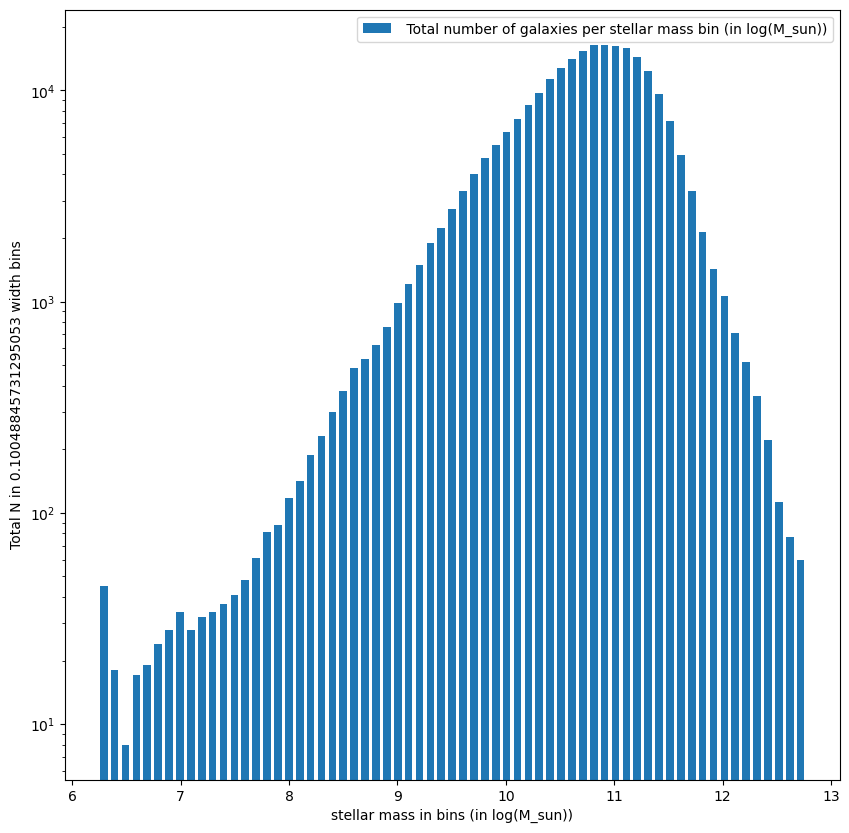

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
width_stellar_mass = change_bin_width * (stellar_mass_binned[1] - stellar_mass_binned[0])
center_stellar_mass = (stellar_mass_binned[:-1] + stellar_mass_binned[1:])/2

ax.bar(center_stellar_mass, N_abs,  align = "center", width = width_stellar_mass, label = " Total number of galaxies per stellar mass bin (in log(M_sun))")
ax.set_xlabel("stellar mass in bins (in log(M_sun))")
y_label_stellar_mass = "Total N in " + str(width_stellar_mass/change_bin_width) + " width bins"
ax.set_ylabel(y_label_stellar_mass)
ax.set_yscale('log')
ax.legend(loc = "upper right")

plt.show()

## Compare coverage to IRON DR

The DESI IRON Data Relase from June 22 is a catalog including basically all data reduction steps and providing very useful information within one table. Now, let's compare the coverage of this release to the EDR data in the same volume, to check how much "progress" was made in this field.

In [14]:
np.min(clean_catalog_EDR["RA"]), np.max(clean_catalog_EDR["RA"])

(148.40325831802127, 273.93378058006977)

In [15]:
np.min(clean_catalog_EDR["DEC"]), np.max(clean_catalog_EDR["DEC"])

(-2.3291467722641253, 67.7513850491988)

In [16]:
np.min(clean_catalog_EDR["Z_HP"]), np.max(clean_catalog_EDR["Z_HP"])

(1.4423111463306655e-05, 0.5997362739291541)

### Of course we need the IRON data for comparison & apply the same selection cuts

This means:
- good redshift
- same volume/area

In [19]:
# Release directory path

specprod = 'iron'    # Internal name for most current data release
specprod_dir = '/global/cfs/cdirs/desi/spectro/redux/iron/'
print(specprod_dir)

/global/cfs/cdirs/desi/spectro/redux/iron/


In [20]:
ztile_cat = Table.read(f'{specprod_dir}/zcatalog/zall-tilecumulative-{specprod}.fits', hdu="ZCATALOG")
#ztile_unm = ztile_cat.copy()

In [21]:
ztile_cat.keep_columns(['TARGETID', 'SURVEY', 'PROGRAM', 'Z', 'ZERR', 'ZWARN', 'TARGET_RA', 'TARGET_DEC', 'FLUX_Z', 'LASTNIGHT'])

In [22]:
ztile_cat = ztile_cat[ztile_cat['ZWARN']==0]

In [23]:
ztile_cat = ztile_cat[(ztile_cat['Z']< np.max(clean_catalog_EDR["Z_HP"]))&(ztile_cat['Z'] > np.min(clean_catalog_EDR["Z_HP"]))]

In [24]:
ii = ztile_cat['TARGET_RA']>(np.min(clean_catalog_EDR["RA"]))
ii &= ztile_cat['TARGET_RA']<(np.max(clean_catalog_EDR["RA"]))
ii &= ztile_cat['TARGET_DEC']>(np.min(clean_catalog_EDR["DEC"]))
ii &= ztile_cat['TARGET_DEC']<(np.max(clean_catalog_EDR["DEC"]))

ztile_cat = ztile_cat[ii]

In [25]:
ztile_cat

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,TARGET_RA,TARGET_DEC,FLUX_Z
int64,bytes7,bytes6,int32,float64,float64,int64,float64,float64,float32
2305843042025759335,main,backup,20220511,0.00014906772113522666,8.975594515287998e-07,0,235.85647093748298,-1.6708985175873938,-99.0
2305843042025757272,main,backup,20220511,0.0003068104282541753,7.720047851131946e-06,0,235.94010324631728,-1.5978009103499367,-99.0
2305843042025762257,main,backup,20220511,2.3664406654331254e-05,4.875420303403359e-06,0,236.35657808540284,-1.4947998566884337,-99.0
2305843042025762113,main,backup,20220511,4.407104200808614e-05,1.0675137088923616e-06,0,236.28049154708967,-1.520958258269812,-99.0
2305843042025753030,main,backup,20220511,3.077658534136445e-05,4.138945335654424e-06,0,236.09387321653028,-1.1415255021284383,-99.0
2305843042025757652,main,backup,20220511,0.00041328143190628525,1.940935742542998e-06,0,235.79318796432094,-1.6749389682783982,-99.0
2305843042025754668,main,backup,20220511,8.488639025737443e-05,1.2169493070038444e-06,0,236.16685339177536,-1.1499079027376007,-99.0
2305843042025749296,main,backup,20220511,5.206739814499873e-05,7.228139440820821e-06,0,236.61105881991423,-1.2720297990527458,-99.0
2305843042025763291,main,backup,20220511,0.0001282344294143049,2.1652997541959446e-06,0,236.2964398901502,-1.3935705154324207,-99.0


### Now we can simply divide the lengths of the table

In [43]:
print("Compared to the IRON DR, the EDR has stellar masses for", len(catalog_EDR)/len(ztile_cat)*100, "% of the objects in the same volume")

Compared to the IRON DR, the EDR has stellar masses for 4.905355861516394 % of the objects in the same volume


In [27]:
len(ztile_cat["SURVEY"])

5401708

In [28]:
len(ztile_cat[ztile_cat["SURVEY"] == "sv3"])

653697